# Timing Functions

This notebook has the results of timing various CSR functions.  It uses the data produced by the benchmark suite and saved in `bench.json`; to prepare that data, run:

    python -m pytest --benchmark-only

In [1]:
import json
import numpy as np
import scipy.sparse as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's load the benchmark data:

In [2]:
with open('bench.json', 'r') as jsf:
    data = json.load(jsf)
list(data.keys())

['machine_info', 'commit_info', 'benchmarks', 'datetime', 'version']

And define a function to get the various benchmark runs:

In [3]:
def get_runs(group, *params):
    marks = [b for b in data['benchmarks'] if b['group'] == group]
    ps = ['kernel'] + list(params)
    runs = {}
    for b in data['benchmarks']:
        if b['group'] != group:
            continue
        
        key = tuple(b['params'][p] for p in ps)
        runs[key] = pd.Series(b['stats']['data'], name='time')
    
    runs = pd.concat(runs, names=ps)
    runs = runs.reset_index(ps)
    runs = runs.reset_index(drop=True)
    return runs

In [4]:
get_runs('MultAB')

,kernel,time
0,scipy,0.000783
1,scipy,0.000909
2,scipy,0.000791
3,scipy,0.000780
4,scipy,0.000780
...,...,...
10886,numba,0.001108
10887,numba,0.001107
10888,numba,0.001104
10889,numba,0.001105


## Matrix Multiplication

Our first benchmark is a simple matrix multiplication.

In [5]:
mab = get_runs('MultAB')
mab['time'] *= 1000
mab.groupby('kernel')['time'].describe()

,count,mean,std,min,25%,50%,75%,max
kernel,,,,,,,,
numba,4526.0,1.153185,0.130961,1.0795,1.0954,1.1120,1.12745,2.5707
scipy,6365.0,0.868763,0.182693,0.7442,0.7675,0.7833,0.87880,2.5468


[]

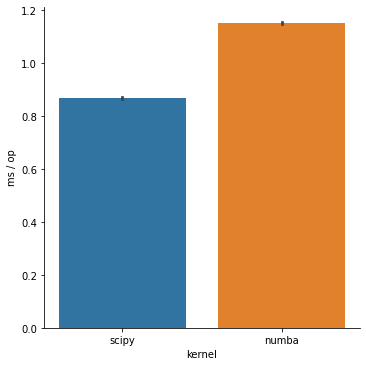

In [6]:
sns.catplot(data=mab, x='kernel', y='time', kind='bar')
plt.ylabel('ms / op')
plt.plot()

And multiplying by the transpose:

In [7]:
mab = get_runs('MultABt')
mab['time'] *= 1000
mab.groupby('kernel')['time'].describe()

,count,mean,std,min,25%,50%,75%,max
kernel,,,,,,,,
numba,4169.0,1.166038,0.125717,1.0953,1.1084,1.1233,1.1443,2.6758
scipy,5397.0,0.950269,0.106856,0.8940,0.9021,0.9178,0.9249,1.9826


[]

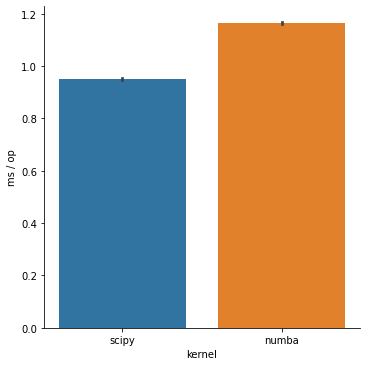

In [8]:
sns.catplot(data=mab, x='kernel', y='time', kind='bar')
plt.ylabel('ms / op')
plt.plot()

### Sweep by Density

We now measure sweeping a 100x100 square matrix multiply by increasing density.

In [9]:
dens = get_runs('MultAB-Density', 'density')
dens['time'] *= 1000

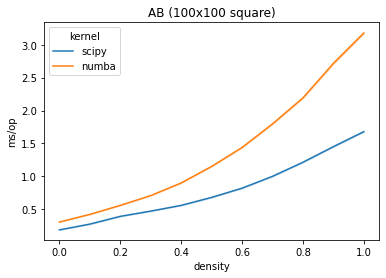

In [10]:
sns.lineplot(data=dens, x='density', y='time', hue='kernel')
plt.title('AB (100x100 square)')
plt.ylabel('ms/op')
plt.show()

And the transpose:

In [11]:
dens = get_runs('MultABt-Density', 'density')
dens['time'] *= 1000

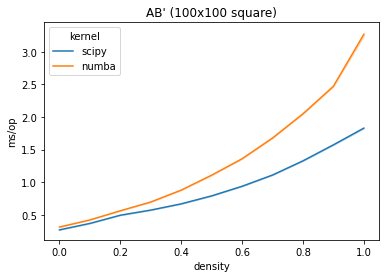

In [12]:
sns.lineplot(data=dens, x='density', y='time', hue='kernel')
plt.title('AB\' (100x100 square)')
plt.ylabel('ms/op')
plt.show()

## Matrix-Vector Multiplication

Now we'll look at matrix/vector multiplication ($A\vec{x}$)

In [13]:
muax = get_runs('MultAx')
muax['time'] *= 1000
muax.groupby('kernel')['time'].describe()

,count,mean,std,min,25%,50%,75%,max
kernel,,,,,,,,
numba,23159.0,0.086705,0.023545,0.0780,0.0795,0.0801,0.0815,0.3996
scipy,21341.0,0.056520,0.021764,0.0446,0.0458,0.0467,0.0522,0.4613


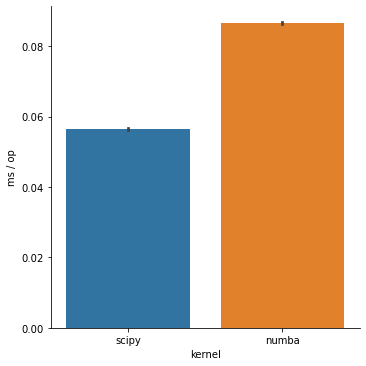

In [14]:
sns.catplot(data=muax, x='kernel', y='time', kind='bar')
plt.ylabel('ms / op')
plt.show()